In [63]:
import pandas as pd
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt


In [64]:
# Copying from Q4 solution
def generate_data(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    split_index = int(len(df) * 2/3)
    reshuffled_df: pd.DataFrame = df.sample(frac=1)
    train_data, test_data = reshuffled_df[:split_index], reshuffled_df[split_index:]
    split_ratio = len(train_data)/len(df)
    #print(f"train-test split is: {split_ratio}")
    X_train, Y_train = train_data.iloc[:,:-1], train_data.iloc[:,-1:]
    X_test, Y_test = test_data.iloc[:,:-1], test_data.iloc[:,-1:]
    return X_train, X_test, Y_train, Y_test

In [65]:
# Generates the cv splits
# returns cv splits as array of tuples
# [(training_indices_split_1, validation_indices_split_1), (..., ...), ...]
def generate_cv_folds(no_of_samples: int):
    no_of_folds = 5
    shuffled_indices = np.random.permutation(no_of_samples)

    fold_sizes = [no_of_samples // no_of_folds] * no_of_folds
    for i in range(no_of_samples % no_of_folds):
        fold_sizes[i] += 1
    
    current = 0
    cv_splits = []

    for fold_size in fold_sizes:
        start = current
        stop = current + fold_size
        val_indices = shuffled_indices[start:stop]
        train_indices = np.concatenate((shuffled_indices[:start], shuffled_indices[stop:]))
        current = stop
        cv_splits.append((train_indices, val_indices))
    
    return cv_splits

In [66]:
exponents_gamma = np.arange(-40, -25, 1)
gamma_values = np.power(2.0, exponents_gamma)

exponents_sigma = np.arange(7, 13.5, 0.5)
sigma_values = np.power(2, exponents_sigma)

In [67]:
def perform_kernelised_ridge_regression(X_train, Y_train, X_test, Y_test, sigma, gamma):
    l_train, d = X_train.shape
    # Calculate kernel matrix for training data (For the current cv split)
    # Reshape X_train_cv to (3,1,2) and (1,3,2) and broadcast
    # To get pairwise differences 
    diff = X_train.values[:, None, :] - X_train.values[None, :, :]
    dist_sq = np.sum(diff**2, axis=2)
    kernel_train = np.exp(-dist_sq / (2 * sigma**2))

    alpha_star = np.linalg.solve(kernel_train + (gamma * l_train * np.eye(l_train)), Y_train)   
    
    Y_train_pred = kernel_train @ alpha_star
    mse_train = np.mean((Y_train_pred - Y_train.values.reshape(-1,1)) ** 2)
    
    # Calculate kernel matrix between training and validation data
    # Using similar concept as above
    X_train_mat = X_train.values
    X_test_mat = X_test.values

    diff = X_test_mat[:, None, :] - X_train_mat[None, :, :]
    dist_sq = np.sum(diff ** 2, axis=2)     
    kernel_val_train = np.exp(-dist_sq / (2 * sigma ** 2))
        
    # Calculate predicted Y and calculate MSE
    Y_val_pred = kernel_val_train @ alpha_star
    Y_true = Y_test.values.reshape(-1,1)

    mse_test = np.mean((Y_val_pred - Y_true) ** 2)
    return mse_test, mse_train

In [68]:
def perform_kernelised_ridge_regression_with_cv(X_train, Y_train, cv_splits, sigma, gamma):
    mse_per_cv_fold = []

    for (training_indices, val_indices) in cv_splits:
        X_train_cv = X_train.iloc[training_indices]
        Y_train_cv = Y_train.iloc[training_indices]
        X_val_cv = X_train.iloc[val_indices]
        Y_val_cv = Y_train.iloc[val_indices]

        mse_test, mse_train = perform_kernelised_ridge_regression(X_train_cv, Y_train_cv, X_val_cv, Y_val_cv, sigma, gamma)
        mse_per_cv_fold.append(mse_test)
    
    return np.mean(mse_per_cv_fold)

In [69]:
def find_best_hyperparameters(X_train, Y_train, cv_splits):
    min_mse = np.inf
    best_gamma = 0
    best_sigma = 0
    cv_error = np.zeros((len(gamma_values), len(sigma_values)))

    for i, gamma in enumerate(gamma_values):
        for j,sigma in enumerate(sigma_values):
            mse = perform_kernelised_ridge_regression_with_cv(X_train, Y_train, cv_splits, sigma, gamma)
            cv_error[i, j] = mse
            if (mse < min_mse):
                min_mse = mse
                best_gamma = gamma
                best_sigma = sigma
    
    return best_gamma, best_sigma, cv_error


In [70]:
df = pd.read_csv('boston_filtered_data.csv')
X_train, X_test, Y_train, Y_test = generate_data(df)

l, d = X_train.shape
cv_splits = generate_cv_folds(l)

best_gamma, best_sigma, cv_error = find_best_hyperparameters(X_train, Y_train, cv_splits)
best_gamma_log = np.log2(best_gamma)
best_sigma_log = np.log2(best_sigma)
print('log of best gamma: ', best_gamma_log)
print('log of best sigma: ', best_sigma_log)

/var/folders/12/vkxv8hm12bn59_9k33xhbfs80000gn/T/ipykernel_29511/3427731021.py:12: RuntimeWarning: divide by zero encountered in matmul
  Y_train_pred = kernel_train @ alpha_star
/var/folders/12/vkxv8hm12bn59_9k33xhbfs80000gn/T/ipykernel_29511/3427731021.py:12: RuntimeWarning: overflow encountered in matmul
  Y_train_pred = kernel_train @ alpha_star
/var/folders/12/vkxv8hm12bn59_9k33xhbfs80000gn/T/ipykernel_29511/3427731021.py:12: RuntimeWarning: invalid value encountered in matmul
  Y_train_pred = kernel_train @ alpha_star
/var/folders/12/vkxv8hm12bn59_9k33xhbfs80000gn/T/ipykernel_29511/3427731021.py:25: RuntimeWarning: divide by zero encountered in matmul
  Y_val_pred = kernel_val_train @ alpha_star
/var/folders/12/vkxv8hm12bn59_9k33xhbfs80000gn/T/ipykernel_29511/3427731021.py:25: RuntimeWarning: overflow encountered in matmul
  Y_val_pred = kernel_val_train @ alpha_star
/var/folders/12/vkxv8hm12bn59_9k33xhbfs80000gn/T/ipykernel_29511/3427731021.py:25: RuntimeWarning: invalid value e

log of best gamma:  -28.0
log of best sigma:  9.0


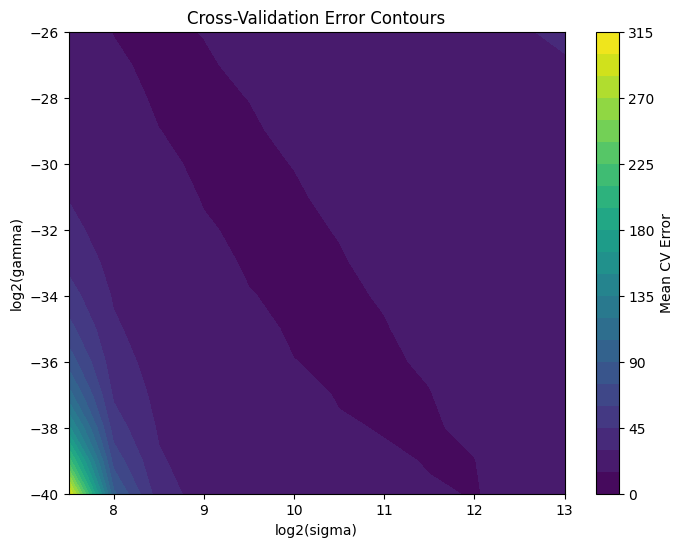

In [72]:
# Plot cross-validation error as a function of gamma and sigma
# In the form of a contour heatmap
cv_error_trimmed = cv_error[:, 1:]
sigma_values_trimmed = sigma_values[1:]
X, Y = np.meshgrid(np.log2(sigma_values_trimmed), np.log2(gamma_values))
plt.figure(figsize=(8,6))
contour = plt.contourf(X, Y, cv_error_trimmed, levels=20, cmap='viridis')
plt.xlabel('log2(sigma)')
plt.ylabel('log2(gamma)')
plt.title('Cross-Validation Error Contours')
plt.colorbar(contour, label='Mean CV Error')
plt.show()

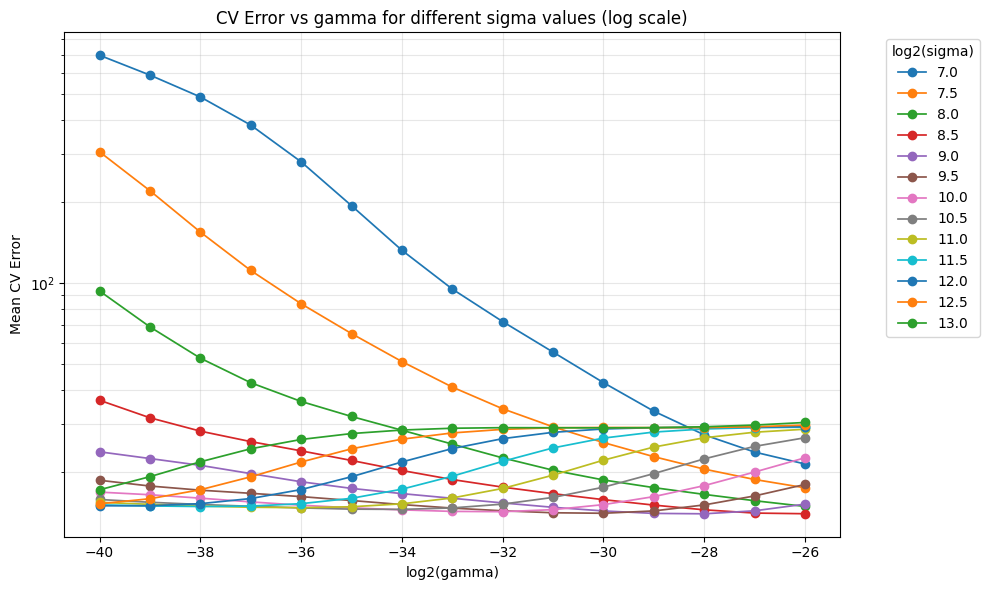

In [ ]:
# Plot cross-validation error as a function of gamma by keeping sigma fixed 
plt.figure(figsize=(10, 6))

# Use log2(gamma) on the x-axis for readability (consistent with contour plot)
x = np.log2(gamma_values)

# Use a small epsilon to avoid zeros on a log y-scale
eps = 1e-8
for j, sigma in enumerate(sigma_values):
    y = cv_error[:, j]
    # Plot and shift slightly to avoid log(0)
    plt.plot(x, y + eps, marker='o', linewidth=1.25, label=f'{np.log2(sigma)}')

plt.xlabel('log2(gamma)')
plt.ylabel('Mean CV Error')
plt.title('CV Error vs gamma for different sigma values (log scale)')
# Use a logarithmic y-scale so both small and very large errors are visible
plt.yscale('log')
plt.legend(title='log2(sigma)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3, which='both')
plt.tight_layout()
plt.show()

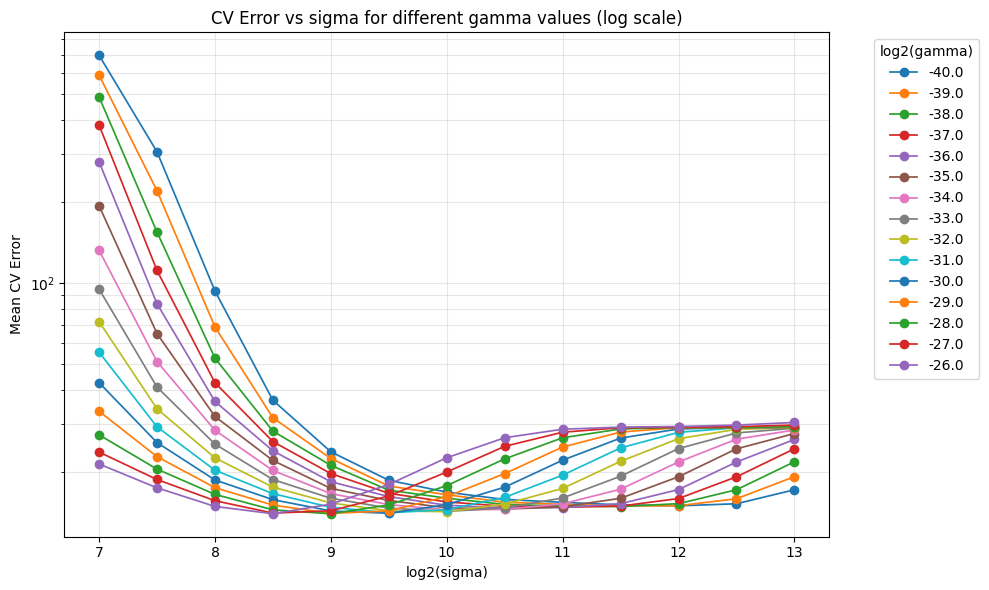

In [74]:
# Plot cross-validation error as a function of sigma by keeping gamma fixed 
plt.figure(figsize=(10, 6))
# Use log2(sigma) on the x-axis for readability (consistent with contour plot)
x = np.log2(sigma_values)
# Use a small epsilon to avoid zeros on a log y-scale
eps = 1e-8
for i, gamma in enumerate(gamma_values):
    y = cv_error[i, :]
    # Plot and shift slightly to avoid log(0)
    plt.plot(x, y + eps, marker='o', linewidth=1.25, label=f'{np.log2(gamma)}')

plt.xlabel('log2(sigma)')
plt.ylabel('Mean CV Error')
plt.title('CV Error vs sigma for different gamma values (log scale)')
# Use a logarithmic y-scale so both small and very large errors are visible
plt.yscale('log')
plt.legend(title='log2(gamma)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3, which='both')
plt.tight_layout()
plt.show()

In [75]:
# Calculate and print MSE over the entire train and test set with the best gamma and alpha values
mse_test, mse_train = perform_kernelised_ridge_regression(X_train, Y_train, X_test, Y_test, best_sigma, best_gamma)
print('mse_train: ', mse_train)
print('mse_test: ', mse_test)


mse_train:  8.680038017560337
mse_test:  9.521216982908967


/var/folders/12/vkxv8hm12bn59_9k33xhbfs80000gn/T/ipykernel_29511/3427731021.py:12: RuntimeWarning: divide by zero encountered in matmul
  Y_train_pred = kernel_train @ alpha_star
/var/folders/12/vkxv8hm12bn59_9k33xhbfs80000gn/T/ipykernel_29511/3427731021.py:12: RuntimeWarning: overflow encountered in matmul
  Y_train_pred = kernel_train @ alpha_star
/var/folders/12/vkxv8hm12bn59_9k33xhbfs80000gn/T/ipykernel_29511/3427731021.py:12: RuntimeWarning: invalid value encountered in matmul
  Y_train_pred = kernel_train @ alpha_star
/var/folders/12/vkxv8hm12bn59_9k33xhbfs80000gn/T/ipykernel_29511/3427731021.py:25: RuntimeWarning: divide by zero encountered in matmul
  Y_val_pred = kernel_val_train @ alpha_star
/var/folders/12/vkxv8hm12bn59_9k33xhbfs80000gn/T/ipykernel_29511/3427731021.py:25: RuntimeWarning: overflow encountered in matmul
  Y_val_pred = kernel_val_train @ alpha_star
/var/folders/12/vkxv8hm12bn59_9k33xhbfs80000gn/T/ipykernel_29511/3427731021.py:25: RuntimeWarning: invalid value e

In [76]:
mse_train_values = []
mse_test_values = []

for i in range(20):
    X_train, X_test, Y_train, Y_test = generate_data(df)

    l, d = X_train.shape
    cv_splits = generate_cv_folds(l)

    best_gamma, best_sigma, cv_error = find_best_hyperparameters(X_train, Y_train, cv_splits)
    mse_test, mse_train = perform_kernelised_ridge_regression(X_train, Y_train, X_test, Y_test, best_sigma, best_gamma)
    mse_train_values.append(mse_train)
    mse_test_values.append(mse_test)

print('MSE train after 20 iterations: ', np.mean(mse_train_values))
print('MSE test after 20 iterations: ', np.mean(mse_test_values))

print('MSE train Std Deviation after 20 iterations: ', np.std(mse_train_values))
print('MSE test Std Deviation after 20 iterations: ', np.std(mse_test_values))


/var/folders/12/vkxv8hm12bn59_9k33xhbfs80000gn/T/ipykernel_29511/3427731021.py:12: RuntimeWarning: divide by zero encountered in matmul
  Y_train_pred = kernel_train @ alpha_star
/var/folders/12/vkxv8hm12bn59_9k33xhbfs80000gn/T/ipykernel_29511/3427731021.py:12: RuntimeWarning: overflow encountered in matmul
  Y_train_pred = kernel_train @ alpha_star
/var/folders/12/vkxv8hm12bn59_9k33xhbfs80000gn/T/ipykernel_29511/3427731021.py:12: RuntimeWarning: invalid value encountered in matmul
  Y_train_pred = kernel_train @ alpha_star
/var/folders/12/vkxv8hm12bn59_9k33xhbfs80000gn/T/ipykernel_29511/3427731021.py:25: RuntimeWarning: divide by zero encountered in matmul
  Y_val_pred = kernel_val_train @ alpha_star
/var/folders/12/vkxv8hm12bn59_9k33xhbfs80000gn/T/ipykernel_29511/3427731021.py:25: RuntimeWarning: overflow encountered in matmul
  Y_val_pred = kernel_val_train @ alpha_star
/var/folders/12/vkxv8hm12bn59_9k33xhbfs80000gn/T/ipykernel_29511/3427731021.py:25: RuntimeWarning: invalid value e

MSE train after 20 iterations:  7.22166830362533
MSE test after 20 iterations:  12.75632400417836
MSE train Std Deviation after 20 iterations:  1.1707359143781253
MSE test Std Deviation after 20 iterations:  1.796567150865895
